This code runs Deep Learning on nutau and nue samples created by Dasha. 

This code runs in a python 3.7 conda environment constructed as follows:
- conda create --name tf-gpu tensorflow-gpu keras scikit-learn matplotlib ipykernel nb_conda_kernels [Pillow]
- conda activate tf-gpu
(Pillow is for image manipulation for making heat maps, but I haven't got it to work yet.  Can remove from environment.)

To run with multiple GPUs on CyberLAMP you must specify the "nodes" and "gpus" qualifiers in the same chunk.  For example:
- qsub -I -A cyberlamp -l qos=cl_higpu -l nodes=1:ppn=1:gpus=4:shared -l mem=24gb -l walltime=4:00:00

In [1]:
import os

# Set which GPU to use.  This probably needs to be done before any other CUDA vars get defined.
# Use the command "nvidia-smi" to get association of a particular GPU with a particular number.
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "0"

In [2]:
from __future__ import division
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from keras import layers
from keras import models

Using TensorFlow backend.


In [3]:
c =0.299792458
n =1.3195
v=c/n 
print(v)

0.2272015596816976


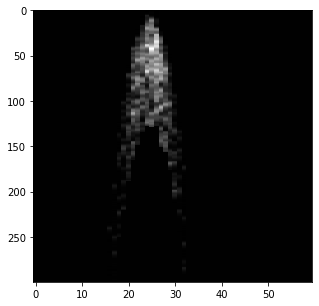

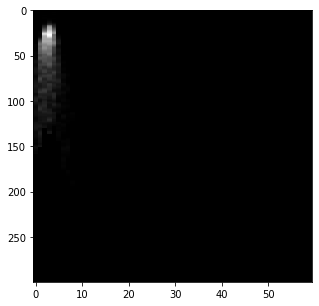

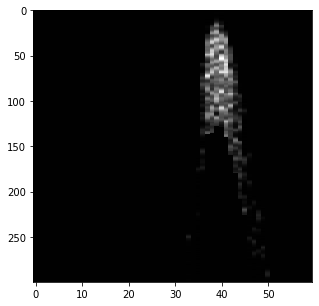

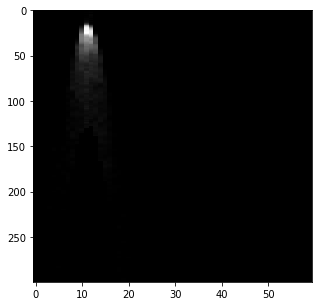

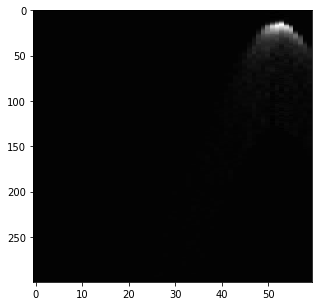

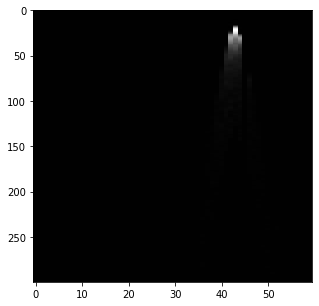

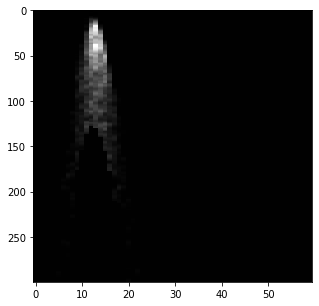

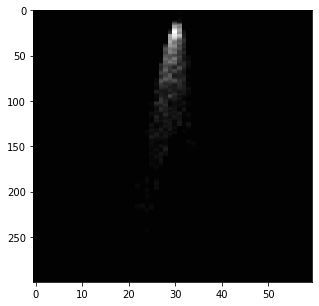

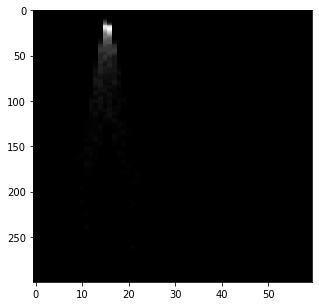

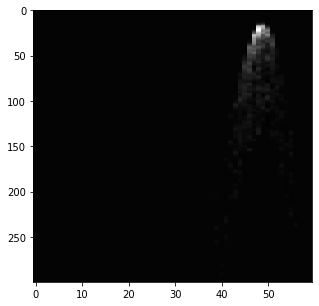

In [4]:
nu_size = 2402105
nu_data = np.memmap('/fastio2/dasha/double_pulse/nu_data_qs5000_qt10000.npy', mode = 'r', dtype ='float32', shape = (nu_size,300,60))
for i in nu_data[:10]:
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111)
    ax.imshow(i, interpolation='nearest', aspect='auto', cmap= 'gray')

In [5]:
print(np.amax(nu_data))
print(np.amin(nu_data))

7.484466e-09
-1.6344187e-10


In [6]:
nu_labels = np.memmap('/fastio2/dasha/double_pulse/nu_label_qs5000_qt10000.npy', mode = 'r', dtype ='float32', shape = (nu_size))
labels = []
for i in nu_labels:
    if i == 4:
        labels.append([0,1])
    elif i == 2:
        labels.append([0,0])
    else:
        labels.append([1,0])
labels = np.array(labels)
print(labels.shape)
print(labels[0:10])

(2402105, 2)
[[1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]
 [1 0]]


In [7]:
print(labels[1400000:1400010])

[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]


In [8]:
print(sum(labels))

[1243137  309305]


In [9]:
idx = np.arange(nu_size)
np.random.shuffle(idx)
print(idx[:10])
print(len(idx))

[ 127717   67854  574536  706608  484382 1537047 1646489  190249 1266912
 2365406]
2402105


In [10]:
no_mu_cc_idx = []
for i in idx:
    if sum(labels[i]) != 0:
        no_mu_cc_idx.append(i)
idx = np.array(no_mu_cc_idx)
print(len(idx))

1552442


In [11]:
train_idx = idx[:100000] 
test_idx = idx[100000:130000] 
valid_idx = idx[130000:160000]

In [12]:
train_data = []
train_labels = []
test_data = []
test_labels = []
valid_data = []
valid_labels = []

for i in train_idx:
    train_data.append(nu_data[i])
    train_labels.append(labels[i])
for i in test_idx:
    test_data.append(nu_data[i])
    test_labels.append(labels[i])
for i in valid_idx:
    valid_data.append(nu_data[i])
    valid_labels.append(labels[i])

train_data = np.array(train_data)
train_labels = np.array(train_labels)
test_data = np.array(test_data)
test_labels = np.array(test_labels)
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
    

In [13]:
print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(valid_data.shape, valid_labels.shape)

(100000, 300, 60) (100000, 2)
(30000, 300, 60) (30000, 2)
(30000, 300, 60) (30000, 2)


In [14]:
print(sum(train_labels))
print(sum(test_labels))
print(sum(valid_labels))

[79866 20134]
[24025  5975]
[24040  5960]


In [15]:
train_data = train_data.reshape((len(train_data),300,60,1))
train_data = train_data.astype('float32')/10**-8
mean = np.mean(train_data)
std = np.std(train_data)
print(mean,std)
train_data = train_data - mean
train_data = train_data/std

valid_data = valid_data.reshape((len(valid_data),300,60,1))
valid_data = valid_data.astype('float32')/10**-8
valid_data = valid_data - mean
valid_data = valid_data/std

test_data = test_data.reshape((len(test_data),300,60,1))
test_data = test_data.astype('float32')/10**-8
test_data = test_data - mean
test_data = test_data/std

0.0012818933 0.014881345


In [16]:
print(np.amax(train_data))
print(np.amin(train_data))

45.287266
-0.72082996


In [17]:
#for im in data_d[:100]:
#    print(im.shape)
#    fig = plt.figure(figsize=(12, 12))
#    ax = fig.add_subplot(111)
#    ax.imshow(im, interpolation='nearest', aspect='auto', cmap= 'gray')
    #ax.plot(im[14,:])
    #print(im[:,46])

In [19]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 60, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
#model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 298, 58, 32)       320       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 149, 29, 32)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 147, 27, 64)       18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 73, 13, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 71, 11, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 35, 5, 128)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 33, 3, 128)        147584    
__________

In [20]:
#model = models.Sequential()
#model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(300, 60, 1)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(64, (3, 3), activation='relu'))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Flatten())
#model.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(2, activation='softmax'))
#model.summary()

In [21]:
from keras import optimizers
import tensorflow as tf

run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

sgd = optimizers.SGD(lr=0.01)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])
#              options = run_opts)

W0903 17:02:53.947142 140625817310976 deprecation_wrapper.py:119] From /home/dup193/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0903 17:02:53.957633 140625817310976 deprecation_wrapper.py:119] From /home/dup193/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [22]:
history = model.fit(train_data,train_labels, epochs=100, validation_data=(valid_data,valid_labels), batch_size =128)

W0903 17:03:07.613959 140625817310976 deprecation.py:323] From /home/dup193/anaconda3/envs/tf-gpu/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 100000 samples, validate on 30000 samples
Epoch 1/100
100000/100000 [==============================] - 50s 497us/step - loss: 0.5132 - acc: 0.7978 - val_loss: 0.4970 - val_acc: 0.8013
Epoch 2/100
100000/100000 [==============================] - 41s 409us/step - loss: 0.5019 - acc: 0.7987 - val_loss: 0.4963 - val_acc: 0.8014
Epoch 3/100
100000/100000 [==============================] - 42s 421us/step - loss: 0.5004 - acc: 0.7988 - val_loss: 0.4966 - val_acc: 0.8014
Epoch 4/100
100000/100000 [==============================] - 39s 394us/step - loss: 0.4998 - acc: 0.7990 - val_loss: 0.4962 - val_acc: 0.8017
Epoch 5/100
100000/100000 [==============================] - 39s 391us/step - loss: 0.4988 - acc: 0.7990 - val_loss: 0.4939 - val_acc: 0.8021
Epoch 6/100
100000/100000 [==============================] - 39s 394us/step - loss: 0.4972 - acc: 0.7993 - val_loss: 0.4925 - val_acc: 0.8025
Epoch 7/100
100000/100000 [==============================] - 39s 387us/step - loss: 0.4966 - acc:

In [23]:
import json
history_dict = history.history # Get the dictionary containing each metric and the loss for each epoch
json.dump(history_dict, open('/data/dfc13/DoublePulse/Models/DP_model_New_3_Qt5000.json', 'w')) # Save it under the form of a json file
#
model.save('/data/dfc13/DoublePulse/Models/DP_model_New_3_Qt5000.h5') # Save the model
#
ResultsFile = open('/data/dfc13/DoublePulse/Models/DP_model_New_3_Qt5000.txt','w') # File for saving the results of the fit.
#
# 8: multiple conv2d layers a la textbook (32 (3,3) then 64, 128, 128, dropout 0.3, dense 256(relu), 64(relu), 2(softmax)
# 8b: same as 8 but with 50 trials
# 8b[not c didn't update the line above]: same as 8b but with dropout 0.5.
# 8c: changed SGC "lr" from 0.01->0.001.  This smoothed things out a lot.  Sort of.  But had 0% accuracy for nutaus.
# 8d: changed SGC "lr" from 0.001->0.005.
# 8e: decreased size of training set to 24k, increased size of validation set to 4k (24k:28k) and increased test set (28k:)
# 8f: changed SGC "lr" from 0.005->0.01.  200 epochs. 97%/37%.
# 8g: lr=0.02, 50 epochs: 98%/29%.

# 9a: changed dense 256 -> 512.  50 epochs. 100%/22%
# 9b: same as above, 200 epochs. 97%/39%.
# 9c: same as above, lr = 0.01.  200 epochs. 97%/36%.
# 9d: same as above, 500 epochs batch_size = 64. 96%/40%.
# 10a: Testing selection of particular GPU.  20 epochs, batch_size = 128.
# 10b: Testing parallelization.  50 epochs, batch_size = 128, one GPU. 98%/22%.
# 10g: 
# New_1: New data (160000 ims)
# New_2_Qt5000: Qst >5000, Qtot >10000
# New_3_Qt5000: No numu, Qst >5000, Qtot >10000
# New_4_Qt5000: No numu, Qst >5000, Qtot >10000, 2 layer

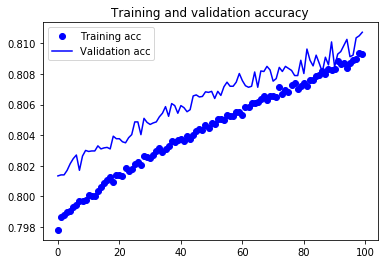

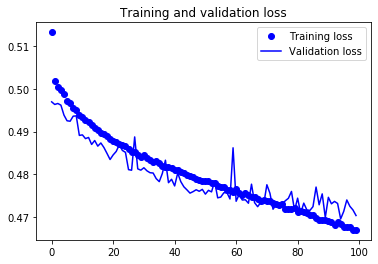

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [25]:
result = model.evaluate(test_data,test_labels)
print(result)

30000/30000 [==============================] - 7s 239us/step
[0.4742070699691772, 0.8095333333333333]


In [26]:
test_pred = model.predict(test_data)

In [27]:
print(test_pred[0:100])
print(test_pred.argmax(axis=1)[0:100])

[[8.1222659e-01 1.8777344e-01]
 [6.2958580e-01 3.7041420e-01]
 [7.2450596e-01 2.7549404e-01]
 [8.2144052e-01 1.7855954e-01]
 [8.6371070e-01 1.3628931e-01]
 [8.1286025e-01 1.8713979e-01]
 [8.4507388e-01 1.5492617e-01]
 [6.9992334e-01 3.0007666e-01]
 [8.6669272e-01 1.3330728e-01]
 [8.0920857e-01 1.9079146e-01]
 [6.9362986e-01 3.0637017e-01]
 [8.3742839e-01 1.6257165e-01]
 [8.1222260e-01 1.8777739e-01]
 [8.1220847e-01 1.8779147e-01]
 [9.5548564e-01 4.4514325e-02]
 [8.1222659e-01 1.8777336e-01]
 [7.3301899e-01 2.6698098e-01]
 [7.1829414e-01 2.8170586e-01]
 [9.6629602e-01 3.3704001e-02]
 [9.4990820e-01 5.0091788e-02]
 [9.1991144e-01 8.0088548e-02]
 [8.2331079e-01 1.7668924e-01]
 [8.7194645e-01 1.2805355e-01]
 [8.1597435e-01 1.8402560e-01]
 [2.8381420e-02 9.7161859e-01]
 [8.1455594e-01 1.8544409e-01]
 [8.0310673e-01 1.9689329e-01]
 [7.9202294e-01 2.0797706e-01]
 [8.1324852e-01 1.8675144e-01]
 [8.1488597e-01 1.8511407e-01]
 [8.5063332e-01 1.4936672e-01]
 [9.0697753e-01 9.3022473e-02]
 [8.1295

In [28]:
matrix = confusion_matrix(test_labels.argmax(axis=1), test_pred.argmax(axis=1))
report = classification_report(test_labels.argmax(axis=1), test_pred.argmax(axis=1))

In [29]:
#print("True Positive",tp)
#print("True Negative",tn)
#print("False Positive",fp)
#print("False Negative",fn)
print(matrix)
print(report)

#ResultsFile.write(repr(matrix))
#ResultsFile.write('\n')
#ResultsFile.write(report)
#ResultsFile.close()

[[23936    89]
 [ 5625   350]]
              precision    recall  f1-score   support

           0       0.81      1.00      0.89     24025
           1       0.80      0.06      0.11      5975

    accuracy                           0.81     30000
   macro avg       0.80      0.53      0.50     30000
weighted avg       0.81      0.81      0.74     30000



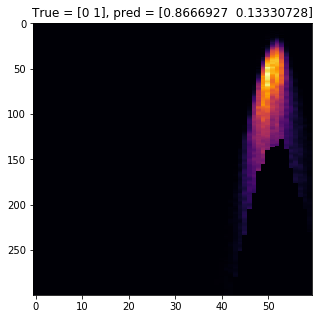

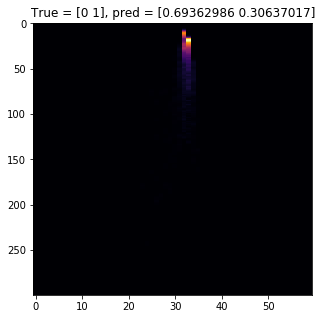

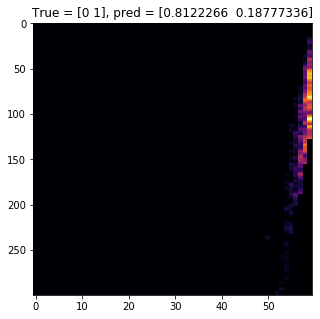

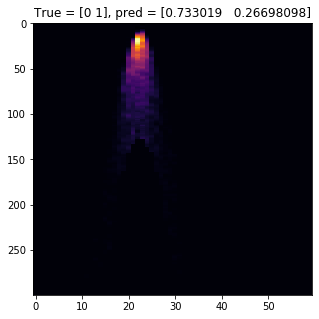

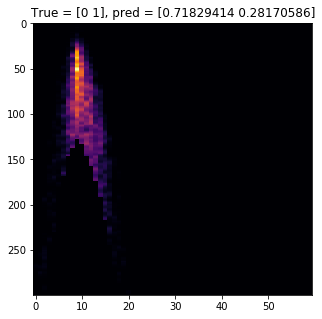

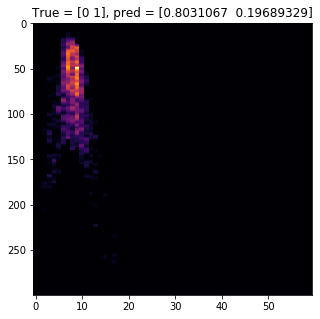

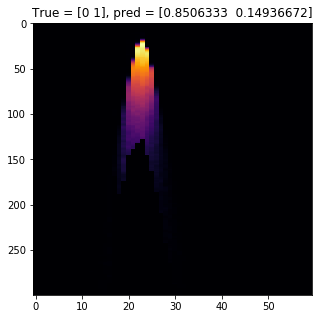

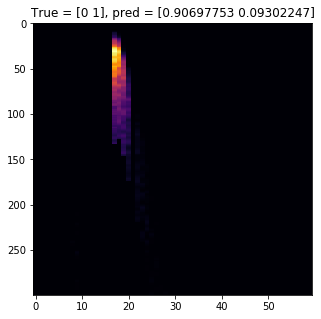

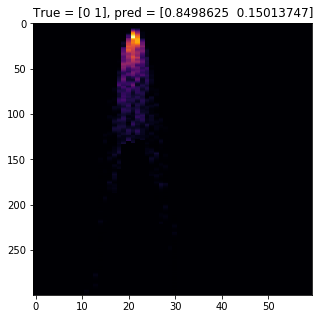

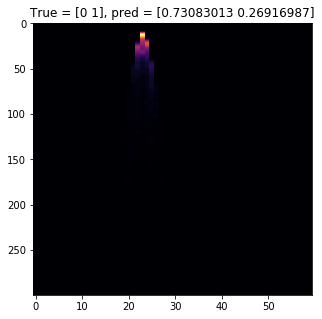

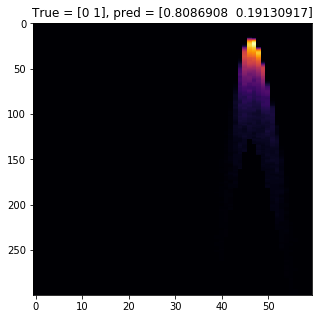

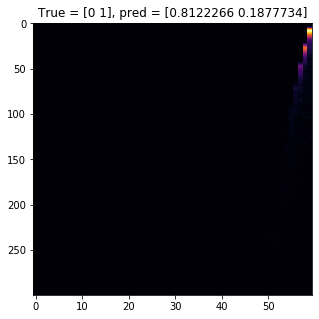

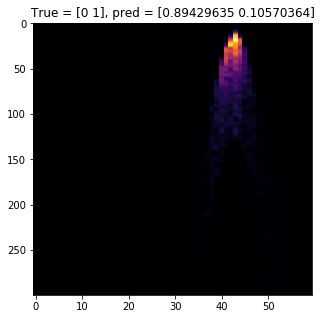

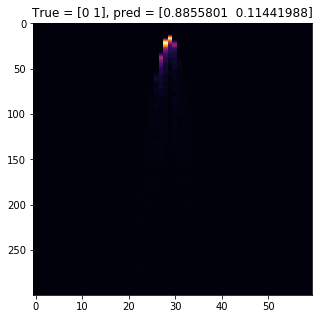

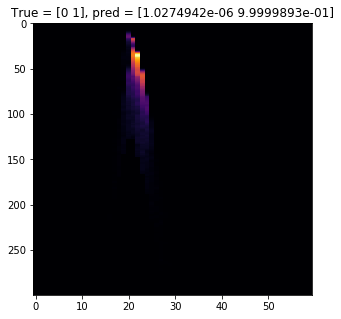

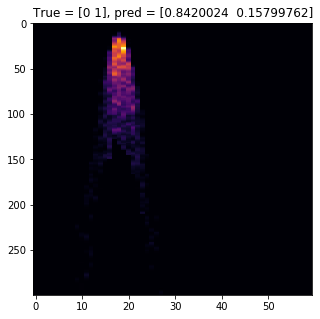

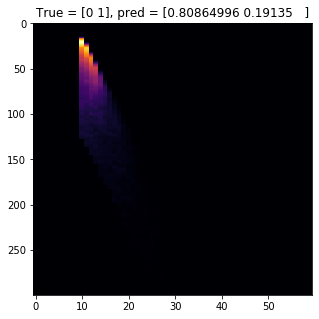

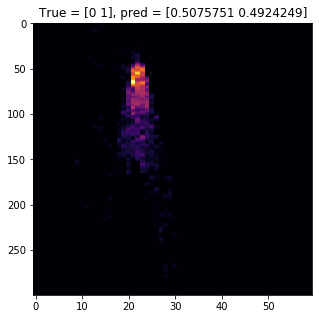

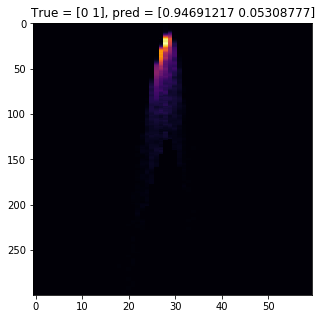

In [30]:
for i, img in enumerate(test_data[:100]):
    if test_labels[i][0] == 0:
        im = img.reshape(300,60)
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(111)
        plt.title('True = {0}, pred = {1}'.format(test_labels[i], test_pred[i]))
        ax.imshow(im, interpolation='nearest', aspect='auto', cmap= 'inferno')